# Caricamento Librerie e Parametri

In [1]:

from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import pandas as pd

import os
from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy
import yaml

from functions import normalize, denormalize

In [2]:
##################################################################
# parameters
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)

# parameters
image_size = config['parameters']['image_size']
total_steps = config['parameters']['total_steps']
learning_rate = config['parameters']['learning_rate']
alpha = config['parameters']['alpha']
beta = config['parameters']['beta']

# path e image
folder_img_original = config['path']['folder_img_original']
folder_img_style = config['path']['folder_img_style']
folder_img_generated = config['path']['folder_img_generated']
name_img_original = config['path']['name_img_original']
name_img_style = config['path']['name_img_style']
name_img_generated = config['path']['name_img_generated']

# creo percorso immagini
path_img_original = os.path.join(folder_img_original, name_img_original)
path_img_style = os.path.join(folder_img_style, name_img_style)
path_img_generated = os.path.join(folder_img_generated, name_img_generated)

# Carico e  Visualizzo le immagini

In [3]:
# creo una funzione per visualizzare le immagini caricate
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()  # modalità interattiva per visualizzare i plot
# plt.ioff() # chuido modalità interattiva

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated

In [4]:
device = torch.device("cpu")

# Funzione per caricare l'immagine e convertirla in un tensore
def load_image(image_name):
    loader = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor()
    ])
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image

# Carica l'immagine
original_img = load_image(path_img_original)
style_img = load_image(path_img_style)

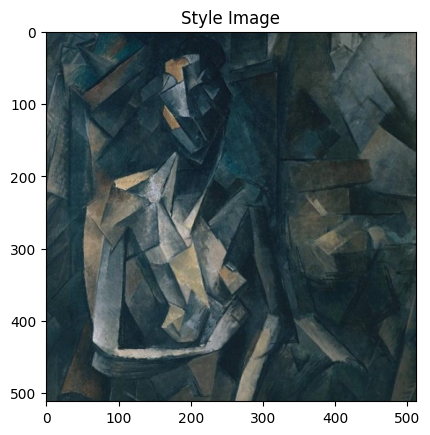

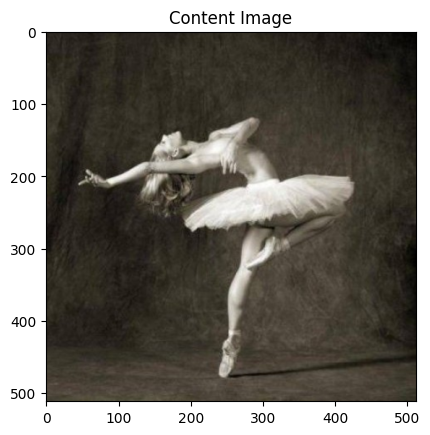

In [5]:
# visualizzo le immagini
plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(original_img, title= 'Content Image')

# Eseguo il transfer color

## Prova seguendo le indicazioni del paper, per adesso non funziona

In [12]:
def compute_mean_covariance(image):
    image_copy = image.clone()
    # Calcola la media e la covarianza dei valori RGB
    batch_size, channels, height, width = image_copy.size()
    image_copy = image_copy.view(batch_size, channels, -1)
    mean = image_copy.mean(dim=2).view(batch_size, channels, 1)
    image_centered = image_copy - mean
    cov = torch.zeros((batch_size, channels, channels), dtype=image_copy.dtype, device=image_copy.device)
    for b in range(batch_size):
        cov[b] = (image_centered[b].mm(image_centered[b].t()) / (height * width))
    return mean, cov

def color_transfer_covariance(source, target):
    source_size = source.size()
    source_copy = source.clone()
    source_mean, source_cov = compute_mean_covariance(source_copy)
    target_mean, target_cov = compute_mean_covariance(target)

    batch_size, channels, height, width = source_size
    transform_matrix = torch.zeros_like(source_cov)

    for b in range(batch_size):
        epsilon = 1e-5
        chol_source = torch.linalg.cholesky(source_cov[b]) + epsilon * torch.eye(channels, device=source_cov.device)
        chol_target = torch.linalg.cholesky(target_cov[b] + epsilon * torch.eye(channels, device=target_cov.device))
    
        transform_matrix[b] = torch.mm(torch.inverse(chol_source), chol_target)

    # Applica la trasformazione all'immagine sorgente
    source_transformed = source_copy.view(batch_size, channels, -1).transpose(1, 2)
    for b in range(batch_size):
        source_transformed[b] = torch.mm(source_transformed[b], transform_matrix[b].t())

    expanded_target_mean = target_mean.view(batch_size, channels, 1, 1).expand_as(target)
    source_transformed = source_transformed.transpose(1, 2).view(source_size) + expanded_target_mean

    return source_transformed

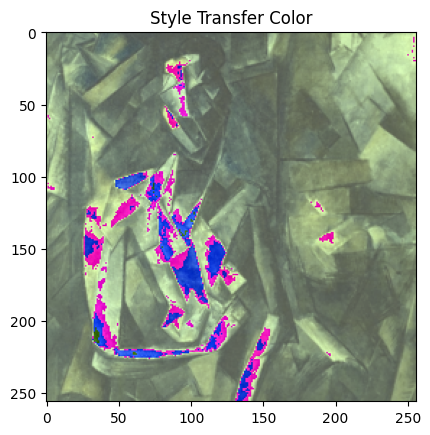

In [13]:
torch.set_grad_enabled(False)
style_img_transformed_normalized = color_transfer_covariance(style_img, original_img)

plt.figure()
imshow(style_img_transformed_normalized, title="Style Transfer Color")

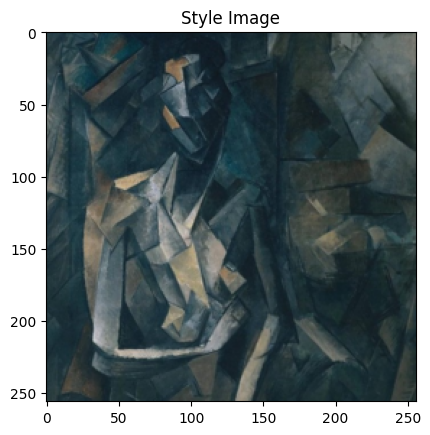

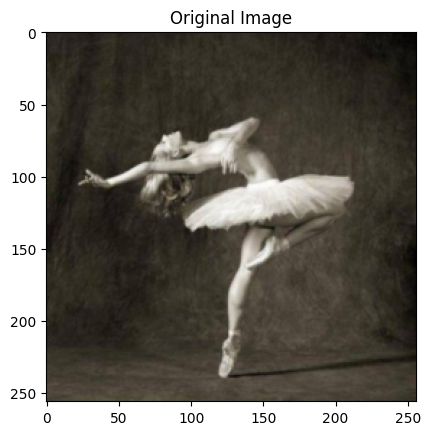

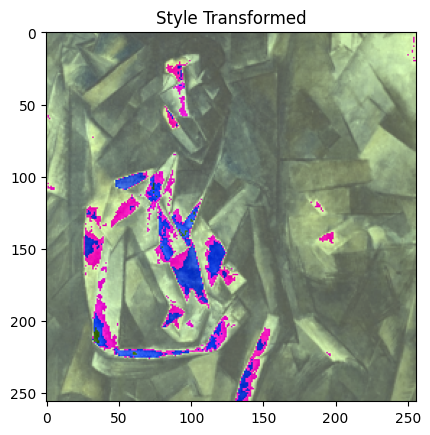

In [9]:
plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(original_img, title='Original Image')
# imshow(style_img_transformed_normalized, title='Style Image Transformed Normalized')

plt.figure()
imshow(style_img_transformed_normalized, title='Style Transformed')

## Transfer Color molto easy, che funziona

In [6]:
def compute_mean_std(image):
    mean = image.mean([2, 3])
    std = image.std([2, 3])
    return mean, std

def color_transfer(source, target):
    source_mean, source_std = compute_mean_std(source)
    target_mean, target_std = compute_mean_std(target)

    # Aggiungi dimensioni extra a mean e std
    source_mean = source_mean.unsqueeze(-1).unsqueeze(-1)
    source_std = source_std.unsqueeze(-1).unsqueeze(-1)
    target_mean = target_mean.unsqueeze(-1).unsqueeze(-1)
    target_std = target_std.unsqueeze(-1).unsqueeze(-1)

    result = (source - source_mean) / source_std
    result = result * target_std + target_mean
    return result

In [7]:
# devo normalizzare prima le immagini per eseguire il trasferimento di colore
style_img_normalized = normalize(style_img)
original_img_normalized = normalize(original_img)

# Applica il trasferimento del colore, ma le immagini devono essere normalizzate!!!
style_img_ct_normalized = color_transfer(style_img_normalized, original_img_normalized)  # trasferisce colore da original_img a style_img

# denormalizzo immagine
style_img_ct = denormalize(style_img_ct_normalized)


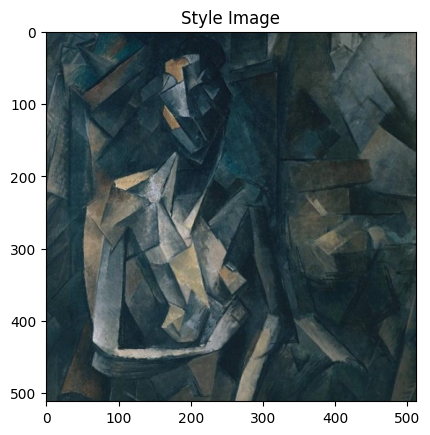

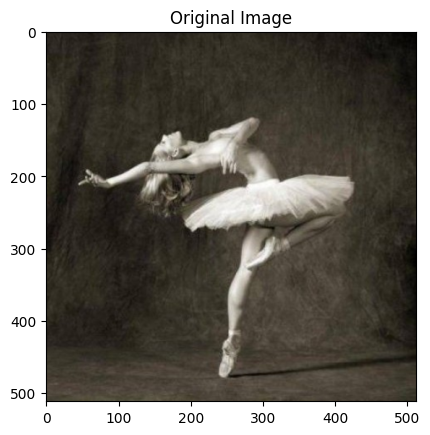

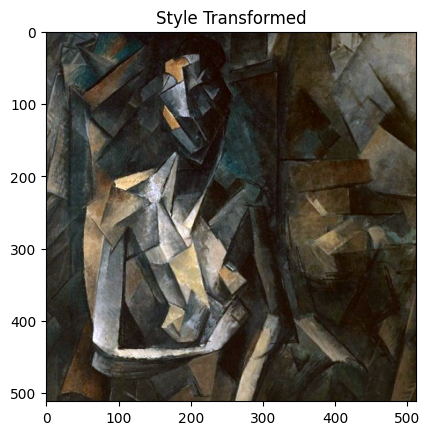

In [8]:
# Visualizzo le immagini per un confronto del trasferimento del colore
plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(original_img, title='Original Image')
# imshow(style_img_transformed_normalized, title='Style Image Transformed Normalized')

plt.figure()
imshow(style_img_ct, title='Style Transformed')

# Definizione del modello VGGTransferStyle

In [14]:
# fin qui posso essere soddisfatto, anche se il traferimento del colore non è il massimo e dovrei testarlo su altre immagini

# cose da fare:
# 1. Sistemare la parte di ottimizzazione del modello   (forse)
# 2. Creare una funzione train() stile articolo con il professore   (ok)
# 3. Denormalizzare il risultato ottenuto, visualizzarlo e infine salvarlo!   (ok)
# 4. Eseguire alcuni test  (training)
# 5. Una volta soddisfatti, creare un file READ ME (chat gpt) e caricarlo su git-hub  (da fare)
# 6. Condividere il progetto su datapizza.tech e instagram   (da fare)

# Extra: migliorare il trasferimento del colore con i tentativi presenti nell'articolo selezionato  (ok, ma non risolto)

In [9]:
# Definisco i layer che voglio modificare del VGG originale pre-trained
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

# Per la fase di addestramento abbiamo bisogno delle immagini normalizzate
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])

# create a module to normalize input image so we can easily put it in a
# ``nn.Sequential``
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = mean.clone().detach().view(-1, 1, 1)
        self.std = std.clone().detach().view(-1, 1, 1)
        
    def forward(self, img):
        # normalize ``img``
        return (img - self.mean) / self.std
    
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input
    
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resize F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input
    

class VGGStyleTransfer(nn.Module):
    def __init__(self, cnn, normalization_mean, normalization_std, style_img, content_img,
                 content_layers=content_layers_default, style_layers=style_layers_default):
        super(VGGStyleTransfer, self).__init__()

        self.normalization = Normalization(normalization_mean, normalization_std).to(device)
        self.content_losses = []
        self.style_losses = []
        self.model = nn.Sequential(self.normalization)

        i = 0
        for layer in cnn.children():
            if isinstance(layer, nn.Conv2d):
                i += 1
                name = 'conv_{}'.format(i)
            elif isinstance(layer, nn.ReLU):
                name = 'relu_{}'.format(i)
                layer = nn.ReLU(inplace=False)
            elif isinstance(layer, nn.MaxPool2d):
                name = 'pool_{}'.format(i)
            elif isinstance(layer, nn.BatchNorm2d):
                name = 'bn_{}'.format(i)
            else:
                raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

            self.model.add_module(name, layer)

            if name in content_layers:
                target = self.model(content_img).detach()
                content_loss = ContentLoss(target)
                self.model.add_module("content_loss_{}".format(i), content_loss)
                self.content_losses.append(content_loss)

            if name in style_layers:
                target_feature = self.model(style_img).detach()
                style_loss = StyleLoss(target_feature)
                self.model.add_module("style_loss_{}".format(i), style_loss)
                self.style_losses.append(style_loss)

        # Trim off the layers after the last content and style losses
        for i in range(len(self.model) - 1, -1, -1):
            if isinstance(self.model[i], ContentLoss) or isinstance(self.model[i], StyleLoss):
                break

        self.model = self.model[:(i + 1)]

    def forward(self, x):
        return self.model(x)


# Addestramento del Modello

In [10]:
# Definisco funzione di addestramento

def train(cnn, optimizer, img_style, img_content, img_input, total_steps, alpha, beta):
    # Inizializza il dataframe per memorizzare le loss
    df = pd.DataFrame(columns=["Step", "Original Loss", "Style Loss", "Total Loss"])

    # Normalizzazione per VGG19
    normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
    normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

    # Crea il modello VGGStyleTransfer
    model = VGGStyleTransfer(cnn, normalization_mean, normalization_std, img_style, img_content).to(device)

    for step in range(total_steps):
        # Resetta le perdite
        for sl in model.style_losses:
            sl.loss = 0
        for cl in model.content_losses:
            cl.loss = 0

        # Esegui il forward pass
        model(img_input)

        style_loss = sum([sl.loss for sl in model.style_losses])
        content_loss = sum([cl.loss for cl in model.content_losses])

        total_loss = alpha * content_loss + beta * style_loss
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        # Salva le loss nel dataframe
        df.loc[step] = [step, content_loss.detach().item(), style_loss.detach().item(), total_loss.detach().item()]

        if step % 5 == 0 and step>0:
            print("Step: {}, Original Loss: {:4f}, Style Loss: {:4f}, Total Loss: {:4f}".format(step, content_loss.detach().item(), style_loss.detach().item(), total_loss.detach().item()))

    return df, img_input



In [11]:
# definisco il modello
cnn = models.vgg19(weights = models.VGG19_Weights.DEFAULT).features.eval()

# creo immagine di input
generated = original_img.clone().requires_grad_(True)

# definisco ottimizzatore
optimizer = optim.Adam([generated], lr = learning_rate)

# addestro il modello
df, result_image = train(cnn, optimizer, style_img_ct, original_img, generated, total_steps, alpha, beta)

Step: 5, Original Loss: 7.868792, Style Loss: 0.004721, Total Loss: 7868792.000000
Step: 10, Original Loss: 5.108299, Style Loss: 0.002691, Total Loss: 5108300.000000
Step: 15, Original Loss: 3.503797, Style Loss: 0.002128, Total Loss: 3503797.250000
Step: 20, Original Loss: 2.334368, Style Loss: 0.002105, Total Loss: 2334368.500000
Step: 25, Original Loss: 1.573697, Style Loss: 0.002245, Total Loss: 1573697.750000
Step: 30, Original Loss: 1.112867, Style Loss: 0.002358, Total Loss: 1112867.500000
Step: 35, Original Loss: 0.834195, Style Loss: 0.002402, Total Loss: 834195.187500
Step: 40, Original Loss: 0.655125, Style Loss: 0.002403, Total Loss: 655125.000000
Step: 45, Original Loss: 0.533811, Style Loss: 0.002374, Total Loss: 533811.062500
Step: 50, Original Loss: 0.450173, Style Loss: 0.002328, Total Loss: 450173.687500
Step: 55, Original Loss: 0.394480, Style Loss: 0.002268, Total Loss: 394480.312500
Step: 60, Original Loss: 0.360493, Style Loss: 0.002204, Total Loss: 360492.812500

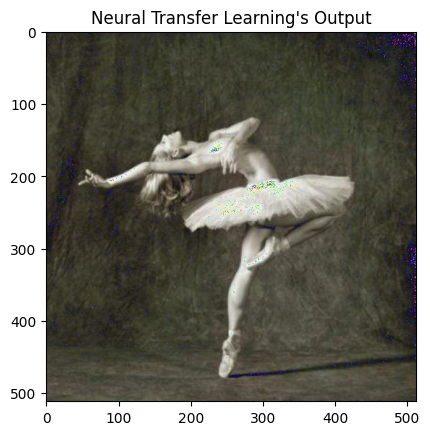

In [12]:
# visualizzo immagine finale
plt.figure()
imshow(result_image, title="Neural Transfer Learning's Output")

In [24]:
# salva immagine

# Converte il tensore PyTorch in un array NumPy
image_numpy = result_image.cpu().detach().numpy()
image_numpy = image_numpy.squeeze()  # Rimuove la dimensione 1
image_numpy = image_numpy.astype('uint8')
image = Image.fromarray(image_numpy.transpose(1, 2, 0))  # Cambia l'ordine delle dimensioni se necessario

# Salva l'immagine come file .png
image.save(path_img_generated)

In [ ]:
# prossimi step:

# 1) far funzionare il codice (ok)
# 2) creare file yaml per la scelta delle immagini!
# 3) provare a modificare il codice con chat gpt
# 4) usare articolo dei colori + chat gpt per mantenere i colori della foto originale anche all'immagine generata